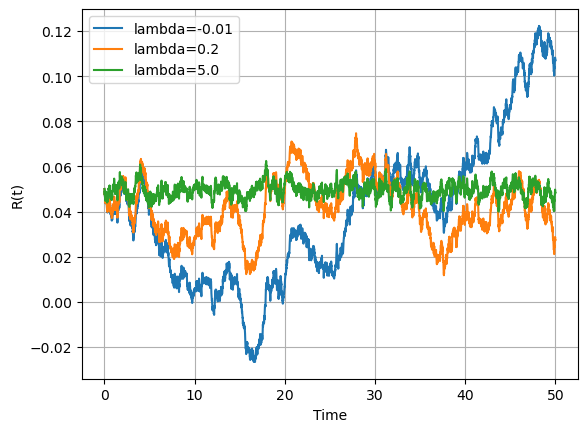

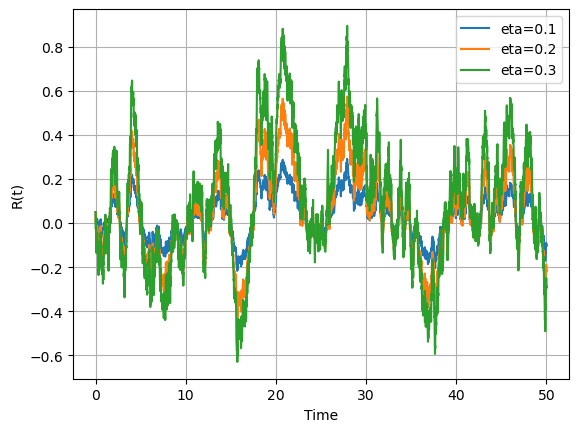

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def generate_paths(num_paths, num_steps, maturity, zero_curve, mean_reversion, volatility):
    # Define forward rate function
    dt = 0.0001
    f0T = lambda t: - (np.log(zero_curve(t + dt)) - np.log(zero_curve(t - dt))) / (2 * dt)
    
    # Initial interest rate
    r0 = f0T(0.00001)
    
    # Define theta function
    theta = lambda t: 1.0 / mean_reversion * (f0T(t + dt) - f0T(t - dt)) / (2.0 * dt) + f0T(t) + \
            volatility * volatility / (2.0 * mean_reversion * mean_reversion) * (1.0 - np.exp(-2.0 * mean_reversion * t))
    
    # Generate paths
    Z = np.random.normal(0.0, 1.0, [num_paths, num_steps])
    W = np.zeros([num_paths, num_steps + 1])
    R = np.zeros([num_paths, num_steps + 1])
    R[:, 0] = r0
    time = np.zeros([num_steps + 1])
    dt = maturity / float(num_steps)
    
    for i in range(num_steps):
        if num_paths > 1:
            Z[:, i] = (Z[:, i] - np.mean(Z[:, i])) / np.std(Z[:, i])
        W[:, i + 1] = W[:, i] + np.sqrt(dt) * Z[:, i]
        R[:, i + 1] = R[:, i] + mean_reversion * (theta(time[i]) - R[:, i]) * dt + volatility * (W[:, i + 1] - W[:, i])
        time[i + 1] = time[i] + dt
        
    # Output paths
    return {"time": time, "R": R}

def plot_effect(data, xlabel, ylabel, legend_labels):
    plt.figure()
    for i, d in enumerate(data):
        np.random.seed(2)
        paths = generate_paths(*d)
        time_grid = paths["time"]
        R = paths["R"]
        plt.plot(time_grid, np.transpose(R), label=legend_labels[i])
    
    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

def main():
    num_paths = 1
    num_steps = 5000
    maturity = 50.0
    zero_curve = lambda T: np.exp(-0.05 * T)
    
    mean_reversion_data = [(num_paths, num_steps, maturity, zero_curve, -0.01, 0.01),
                           (num_paths, num_steps, maturity, zero_curve, 0.2, 0.01),
                           (num_paths, num_steps, maturity, zero_curve, 5.0, 0.01)]
    plot_effect(mean_reversion_data, "Time", "R(t)", ['lambda=-0.01', 'lambda=0.2', 'lambda=5.0'])
    
    volatility_data = [(num_paths, num_steps, maturity, zero_curve, 0.5, 0.1),
                       (num_paths, num_steps, maturity, zero_curve, 0.5, 0.2),
                       (num_paths, num_steps, maturity, zero_curve, 0.5, 0.3)]
    plot_effect(volatility_data, "Time", "R(t)", ['eta=0.1', 'eta=0.2', 'eta=0.3'])

if __name__ == "__main__":
    main()


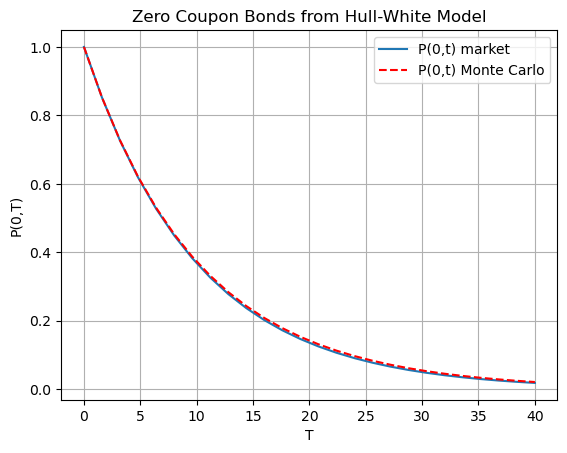

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def instantaneous_forward_rate(t, P0T):
    """
    Calculate the instantaneous forward rate using central difference method.
    
    Args:
    t: Time
    P0T: Zero coupon bond price function
    
    Returns:
    Instantaneous forward rate
    """
    dt = 0.01    
    expr = - (np.log(P0T(t + dt)) - np.log(P0T(t - dt))) / (2 * dt)
    return expr

def generate_paths_hw_euler(num_paths, num_steps, maturity, P0T, lambd, eta):    
    """
    Generate paths of Hull-White model using Euler discretization.
    
    Args:
    num_paths: Number of paths
    num_steps: Number of time steps
    maturity: Maturity of the paths
    P0T: Zero coupon bond price function
    lambd: Lambda parameter of the Hull-White model
    eta: Eta parameter of the Hull-White model
    
    Returns:
    Dictionary containing time, short rate, and zero coupon bond paths
    """
    # Initial interest rate is a forward rate at time t->0
    r0 = instantaneous_forward_rate(0.01, P0T)
    
    dt = maturity / float(num_steps)
    time_grid = np.linspace(0, maturity, num_steps + 1)
    
    Z = np.random.normal(0.0, 1.0, [num_paths, num_steps])
    W = np.zeros([num_paths, num_steps + 1])
    R = np.zeros([num_paths, num_steps + 1])
    M = np.zeros([num_paths, num_steps + 1])
    M[:, 0] = 1.0
    R[:, 0] = r0
    
    for i in range(num_steps):
        # Standardize normal samples
        if num_paths > 1:
            Z[:, i] = (Z[:, i] - np.mean(Z[:, i])) / np.std(Z[:, i])
        
        # Euler scheme for short rate and bond price
        W[:, i + 1] = W[:, i] + np.sqrt(dt) * Z[:, i]
        R[:, i + 1] = R[:, i] + lambd * (hw_theta(time_grid[i], lambd, eta, P0T) - R[:, i]) * dt + \
                      eta * (W[:, i + 1] - W[:, i])
        M[:, i + 1] = M[:, i] * np.exp((R[:, i + 1] + R[:, i]) * 0.5 * dt)
    
    # Outputs
    paths = {"time": time_grid, "R": R, "M": M}
    return paths

def hw_theta(t, lambd, eta, P0T):
    """
    Calculate the theta function for the Hull-White model.
    
    Args:
    t: Time
    lambd: Lambda parameter of the Hull-White model
    eta: Eta parameter of the Hull-White model
    P0T: Zero coupon bond price function
    
    Returns:
    Theta function
    """
    dt = 0.01    
    theta = 1.0 / lambd * (instantaneous_forward_rate(t + dt, P0T) - instantaneous_forward_rate(t - dt, P0T)) / \
            (2.0 * dt) + instantaneous_forward_rate(t, P0T) + eta * eta / (2.0 * lambd * lambd) * \
            (1.0 - np.exp(-2.0 * lambd * t))
    return theta

def main_calculation():
    # Parameters
    num_paths = 25000
    num_steps = 25
    lambd = 0.02
    eta = 0.02
    
    # Zero coupon bond curve function
    P0T = lambda T: np.exp(-0.1 * T)
    
    # Generate paths
    maturity = 40
    paths = generate_paths_hw_euler(num_paths, num_steps, maturity, P0T, lambd, eta)
    ti = paths["time"]
    M = paths["M"]
    
    # Calculate Monte Carlo zero coupon bond prices
    P_t_MC = np.zeros(num_steps + 1)
    for i in range(num_steps + 1):
        P_t_MC[i] = np.mean(1.0 / M[:, i])
    
    # Plot results
    plt.figure(1)
    plt.grid()
    plt.xlabel('T')
    plt.ylabel('P(0,T)')
    plt.plot(ti, P0T(ti))
    plt.plot(ti, P_t_MC, '--r')
    plt.legend(['P(0,t) market', 'P(0,t) Monte Carlo'])
    plt.title('Zero Coupon Bonds from Hull-White Model')
    plt.show()

main_calculation()
